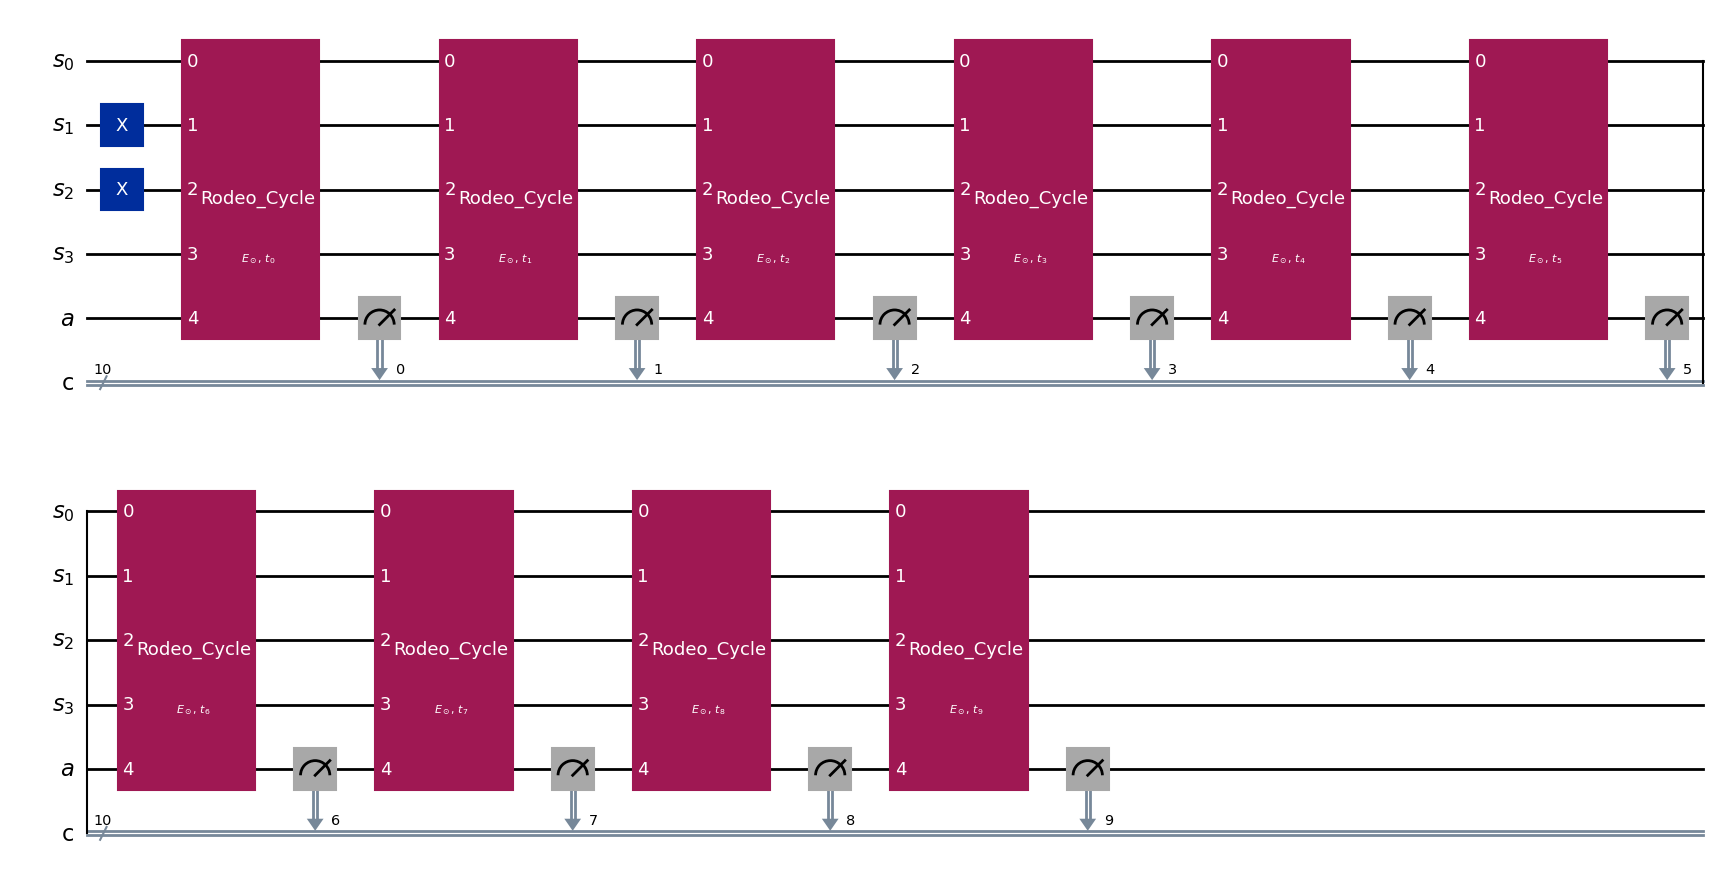

In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter

# # Define Fermi-Hubbard interaction gates for hopping and on-site terms
# Hopping Gate
def create_hopping_gate(J, delta_t):
    f_circ = QuantumCircuit(2)
    f_circ.h([0, 1])
    f_circ.s([0, 1])
    f_circ.h([0, 1])
    f_circ.cx(0, 1)
    f_circ.h(1)
    f_circ.z(1)
    f_circ.s([0, 1])
    f_circ.h([0, 1])
    f_gate = f_circ.to_gate(label='F_gate')
    
    g_circ = QuantumCircuit(2)
    g_circ.h([0, 1])
    g_circ.z(0)
    g_circ.s([0, 1])
    g_circ.h(1)
    g_circ.cx(0, 1)
    g_circ.h([0, 1])
    g_circ.z([0, 1])
    g_circ.s([0, 1])
    g_circ.h([0, 1])
    g_gate = g_circ.to_gate(label='G_gate')

    # The code below created a factor of 2 off
    # hop_circ = QuantumCircuit(2)
    # hop_circ.append(f_gate, [0, 1])
    # hop_circ.ry((J * delta_t) / 2, 0)
    # hop_circ.ry((-1*J * delta_t) / 2, 1)
    # hop_circ.append(g_gate, [0, 1])

    hop_circ = QuantumCircuit(2)
    hop_circ.append(f_gate, [0, 1])
    hop_circ.ry((J * delta_t), 0)
    hop_circ.ry((-1*J * delta_t), 1)
    hop_circ.append(g_gate, [0, 1])
    return hop_circ.to_gate(label=fr"A_gate_{J}")

# On-site interaction gate
def create_onsite_gate(U, delta_t):
    onsite_circ = QuantumCircuit(2)
    onsite_circ.cx(0, 1)
    onsite_circ.rz(2*U * delta_t, 1)
    onsite_circ.cx(0, 1)
    return onsite_circ.to_gate(label=fr"B_gate_{U}")

# Define the rodeo cycle
def rodeo_cycle(num_sites, J_value, U_value, t: Parameter, r, targ: Parameter):
    beta = t / r  # Parameter for rotation gates
    num_qubits = num_sites * 2  # Each site has two qubits (spin-up and spin-down)

    # Define quantum registers
    sys = QuantumRegister(num_qubits, 's')
    aux = QuantumRegister(1, 'a')
    qc = QuantumCircuit(sys, aux)

    # Apply Hadamard on the auxiliary qubit to create superposition
    qc.h(aux[0])

    # Trotter evolution within this single Rodeo cycle
    A_gate = create_hopping_gate(J=-J_value, delta_t=beta)
    # A_gate = create_hopping_gate(J=-2*J_value, delta_t=beta)
    B_gate = create_onsite_gate(U=U_value, delta_t=beta)

    qc.cz([sys[0], sys[1]], aux[0])
    for _ in range(r):
    
        # qc.cz([sys[0], sys[1]], aux[0])
        # Apply A_gate for hopping terms on nearest neighbors for spin-up qubits
        for site in range(0, num_sites - 1, 2):  # Even sites for spin-up qubits
            spin_up_qubit_1 = site * 2
            spin_up_qubit_2 = (site + 1) * 2
            qc.append(A_gate, [spin_up_qubit_1, spin_up_qubit_2])

        for site in range(1, num_sites - 1, 2):  # Odd sites for spin-up qubits
            spin_up_qubit_1 = site * 2
            spin_up_qubit_2 = (site + 1) * 2
            qc.append(A_gate, [spin_up_qubit_1, spin_up_qubit_2])

        # Apply A_gate for hopping terms on nearest neighbors for spin-down qubits
        for site in range(0, num_sites - 1, 2):  # Even sites for spin-down qubits
            spin_down_qubit_1 = site * 2 + 1
            spin_down_qubit_2 = (site + 1) * 2 + 1
            qc.append(A_gate, [spin_down_qubit_1, spin_down_qubit_2])

        for site in range(1, num_sites - 1, 2):  # Odd sites for spin-down qubits
            spin_down_qubit_1 = site * 2 + 1
            spin_down_qubit_2 = (site + 1) * 2 + 1
            qc.append(A_gate, [spin_down_qubit_1, spin_down_qubit_2])

        # qc.cz([sys[0], sys[1]], aux[0])

        # Add CX gates for every other system qubit
        for i in range(0, num_qubits, 4):
            qc.cx(aux[0], sys[i])  # Controlled X on selected system qubits
            if i + 2 < num_qubits:
                qc.cx(aux[0], sys[i + 2])

        # Apply B_gate for on-site interactions on each site
        for site in range(num_sites):
            spin_up_qubit = site * 2
            spin_down_qubit = site * 2 + 1
            qc.append(B_gate, [spin_up_qubit, spin_down_qubit])

        # # Add CX gates for every other system qubit again
        for i in range(0, num_qubits, 4):
            qc.cx(aux[0], sys[i])  # Controlled X on selected system qubits
            if i + 2 < num_qubits:
                qc.cx(aux[0], sys[i + 2])
        
    qc.cz([sys[0], sys[1]], aux[0])


    # Phase rotation based on the energy target and time sample
    qc.p(2*targ * t, aux[0])
    qc.h(aux[0])

    return qc

# Define parameters
num_sites = 2
J_input = 4.0
U_input = 1.0
cycles = 10

# Initialize system parameters
target = Parameter(r'$E_\odot$')
time = [Parameter(fr'$t_{i}$') for i in range(cycles)]
steps = 5

# Create a list of target energies at the same length of the cycle
targ_list = [target] * cycles

# Create registers and circuit
classical = ClassicalRegister(cycles, 'c')
aux = QuantumRegister(1, 'a')
sys = QuantumRegister(num_sites * 2, 's')
circuit = QuantumCircuit(sys, aux, classical)

circuit.x([sys[1], sys[2]])

# Create circuit with rodeo cycles
for j in range(cycles):
    rodeo_gate= rodeo_cycle(num_sites=2, J_value=J_input, U_value=U_input, t=time[j], r=steps, targ=target)
    circuit.append(rodeo_gate.to_gate(label = fr'Rodeo_Cycle'), range(num_sites * 2 + 1))
    circuit.measure(aux, classical[j])  # Ensure that the measurement of `aux` qubit is mapped to the `j`-th classical bit
    

circuit.draw('mpl')


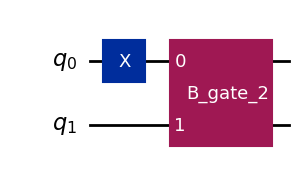

In [83]:
U_value = 2
beta = 0.1
B_gate = create_onsite_gate(U=U_value, delta_t=beta)
ncirc = QuantumCircuit(2)
ncirc.x(0)
ncirc.append(B_gate, [0,1])
ncirc.draw('mpl')

In [84]:
# Conservation Test
from qiskit.quantum_info import Statevector

# Get the statevector
state = Statevector.from_instruction(ncirc)

# Display the statevector
print("Statevector:", state)



Statevector: Statevector([0.        +0.j        , 0.98006658+0.19866933j,
             0.        +0.j        , 0.        +0.j        ],
            dims=(2, 2))


In [85]:
from qiskit.quantum_info import Statevector

# Define a test circuit with A_gate
test_circuit = QuantumCircuit(2)
test_circuit.append(create_hopping_gate(J=1.0, delta_t=0.1), [0, 1])

# Get the statevector for an initial |10> state
state = Statevector.from_label('10')  # Initial state |10>
final_state = state.evolve(test_circuit)

# Print the statevector
print("Statevector after A_gate:", final_state)


Statevector after A_gate: Statevector([0.        +0.j        , 0.        +0.04997917j,
             0.99875026+0.j        , 0.        +0.j        ],
            dims=(2, 2))


In [34]:
def create_hopping_gate(J, delta_t):
    f_circ = QuantumCircuit(2)
    f_circ.h([0, 1])
    f_circ.s([0, 1])
    f_circ.h([0, 1])
    f_circ.cx(0, 1)
    f_circ.h(1)
    f_circ.z(1)
    f_circ.s([0, 1])
    f_circ.h([0, 1])
    f_gate = f_circ.to_gate(label='F_gate')
    
    g_circ = QuantumCircuit(2)
    g_circ.h([0, 1])
    g_circ.z(0)
    g_circ.s([0, 1])
    g_circ.h(1)
    g_circ.cx(0, 1)
    g_circ.h([0, 1])
    g_circ.z([0, 1])
    g_circ.s([0, 1])
    g_circ.h([0, 1])
    g_gate = g_circ.to_gate(label='G_gate')

    # The code below created a factor of 2 off
    # hop_circ = QuantumCircuit(2)
    # hop_circ.append(f_gate, [0, 1])
    # hop_circ.ry((J * delta_t) / 2, 0)
    # hop_circ.ry((-1*J * delta_t) / 2, 1)
    # hop_circ.append(g_gate, [0, 1])

    hop_circ = QuantumCircuit(2)
    hop_circ.append(f_gate, [0, 1])
    hop_circ.ry((J * delta_t/2), 0)
    hop_circ.ry((-1*J * delta_t/2), 1)
    hop_circ.append(g_gate, [0, 1])
    return hop_circ.to_gate(label=fr"A_gate_{J}")

In [29]:
def create_hopping_gate2(J, delta_t):
    f_circ = QuantumCircuit(2)
    f_circ.h([0, 1])
    f_circ.s([0, 1])
    f_circ.h([0, 1])
    f_circ.cx(0, 1)
    f_circ.h(1)
    f_circ.z(1)
    f_circ.s([0, 1])
    f_circ.h([0, 1])
    f_gate = f_circ.to_gate(label='F_gate')
    
    g_circ = QuantumCircuit(2)
    g_circ.h([0, 1])
    g_circ.z(0)
    g_circ.s([0, 1])
    g_circ.h(1)
    g_circ.cx(0, 1)
    g_circ.h([0, 1])
    g_circ.z([0, 1])
    g_circ.s([0, 1])
    g_circ.h([0, 1])
    g_gate = g_circ.to_gate(label='G_gate')

    # The code below created a factor of 2 off
    # hop_circ = QuantumCircuit(2)
    # hop_circ.append(f_gate, [0, 1])
    # hop_circ.ry((J * delta_t) / 2, 0)
    # hop_circ.ry((-1*J * delta_t) / 2, 1)
    # hop_circ.append(g_gate, [0, 1])


    hop_circ = QuantumCircuit(2)
    hop_circ.z([0])
    hop_circ.append(f_gate, [0, 1])
    hop_circ.ry((J * delta_t/2), 0)
    hop_circ.ry((-1*J * delta_t/2), 1)
    hop_circ.append(g_gate, [0, 1])
    hop_circ.z([0])
    return hop_circ.to_gate(label=fr"A_gate_{J}")

In [40]:
from qiskit.circuit.library import RZZGate, RXXGate, RYYGate
from qiskit.quantum_info import Operator
import sympy as sym


In [52]:
from qiskit.circuit.library import RZZGate, RXXGate, RYYGate
circ = QuantumCircuit(2)
delta_t = 0.1
J_value = 2
rxx_gate = RXXGate(J_value*delta_t)
ryy_gate = RYYGate(J_value*delta_t)
# circ.z([0])
circ.append(rxx_gate, [0,1])
circ.append(ryy_gate, [0,1])
# circ.z([0])
circ.draw('mpl')
xxyy_gate = circ.to_gate(label = "XXYY_Gate")


In [53]:
sym.Matrix(Operator(xxyy_gate).data)

Matrix([
[1.0,                    0,                    0,   0],
[  0,    0.980066577841242, -0.198669330795061*I,   0],
[  0, -0.198669330795061*I,    0.980066577841242,   0],
[  0,                    0,                    0, 1.0]])

In [31]:
from qiskit.circuit.library import RZZGate, RXXGate, RYYGate
from qiskit.quantum_info import Operator
import sympy as sym

# Define the RXXGate and RYYGate
delta_t = 0.1
J_value = 2
rxx_gate = RXXGate(J_value*delta_t)
ryy_gate = RYYGate(J_value*delta_t)
xy_gate = Operator(rxx_gate) @ Operator(ryy_gate)
A_gate = create_hopping_gate(J=2*J_value, delta_t=delta_t)
A_gate2 = create_hopping_gate2(J=2*J_value, delta_t=delta_t)

# Print the unitary matrix
sym.Matrix(Operator(xy_gate).data)


Matrix([
[1.0,                    0,                    0,   0],
[  0,    0.980066577841242, -0.198669330795061*I,   0],
[  0, -0.198669330795061*I,    0.980066577841242,   0],
[  0,                    0,                    0, 1.0]])

In [32]:
sym.Matrix(Operator(A_gate).data)

Matrix([
[     0.999999999999999,                   0,                   0, 1.11022302462516e-16*I],
[                     0,   0.980066577841241, 0.198669330795061*I,                      0],
[                     0, 0.198669330795061*I,   0.980066577841241,                      0],
[1.11022302462516e-16*I,                   0,                   0,      0.999999999999999]])

In [33]:
sym.Matrix(Operator(A_gate2).data)

Matrix([
[      0.999999999999999,                    0,                    0, -1.11022302462516e-16*I],
[                      0,    0.980066577841241, -0.198669330795061*I,                       0],
[                      0, -0.198669330795061*I,    0.980066577841241,                       0],
[-1.11022302462516e-16*I,                    0,                    0,       0.999999999999999]])

In [26]:
from qiskit.circuit.library import RZZGate, RXXGate, RYYGate
from qiskit.quantum_info import Operator
import sympy as sym

# Define the RXXGate and RYYGate
delta_t = 0.1
J_value = 2
rxx_gate = RXXGate(J_value*delta_t)
ryy_gate = RYYGate(J_value*delta_t)
xy_gate = Operator(rxx_gate) @ Operator(ryy_gate)
A_gate = create_hopping_gate(J=-2*J_value, delta_t=delta_t)

# Print the unitary matrix
Operator(xy_gate).data


array([[1.        +0.j        , 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.98006658+0.j        ,
        0.        -0.19866933j, 0.        +0.j        ],
       [0.        +0.j        , 0.        -0.19866933j,
        0.98006658+0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.        +0.j        , 1.        +0.j        ]])

In [2]:
import scipy.linalg as scp

I = np.array([[1, 0], [0, 1]])
S_plus = np.array([[0, 1], [0, 0]])  # Raising operator
S_minus = np.array([[0, 0], [1, 0]])  # Lowering operator
Z = np.array([[1, 0], [0, -1]])
X = np.array([[0,1],[1,0]])
Y = np.array([[0, -1j], [1j, 0]])
zero = np.array([1,0])
one = np.array([0,1])

evolution_operator = scp.expm(2*-1j*0.1*np.kron(Z, Z))
state2 = np.kron(zero, one)

state2 = evolution_operator @ state2

print(state2)

[0.        +0.j         0.98006658+0.19866933j 0.        +0.j
 0.        +0.j        ]


In [44]:
import sympy as sym
delta_t = 0.1
J_value = 2
XY = np.kron(X,X) + np.kron(Y,Y)
expXY = scp.expm(J_value*delta_t*-1j*XY)
sym.Matrix(expXY)

Matrix([
[1.0,                    0,                    0,   0],
[  0,    0.921060994002885, -0.389418342308651*I,   0],
[  0, -0.389418342308651*I,    0.921060994002885,   0],
[  0,                    0,                    0, 1.0]])

In [50]:
delta_t = 0.1
J_value = 2
rxx_gate = RXXGate(J_value*delta_t)
ryy_gate = RYYGate(J_value*delta_t)
xy_gate = Operator(rxx_gate) @ Operator(ryy_gate)
A_gate = create_hopping_gate(J=-2*J_value, delta_t=delta_t)

sym.Matrix(Operator(A_gate).data)

Matrix([
[0.999999999999999,                   0,                   0,                 0],
[                0,   0.921060994002884, -0.38941834230865*I,                 0],
[                0, -0.38941834230865*I,   0.921060994002884,                 0],
[                0,                   0,                   0, 0.999999999999999]])

In [45]:
import sympy as sym
delta_t = 0.1
J_value = 2
spin_op = np.kron(S_plus,S_minus) + np.kron(S_minus,S_plus)
expXY = scp.expm(2*J_value*delta_t*-1j*spin_op)
sym.Matrix(expXY)

Matrix([
[1.0,                    0,                    0,   0],
[  0,    0.921060994002885, -0.389418342308651*I,   0],
[  0, -0.389418342308651*I,    0.921060994002885,   0],
[  0,                    0,                    0, 1.0]])

In [46]:
sym.Matrix(spin_op)

Matrix([
[0, 0, 0, 0],
[0, 0, 1, 0],
[0, 1, 0, 0],
[0, 0, 0, 0]])

In [22]:
ZZ = np.kron(Z, Z)
ZI = np.kron(Z, I)

sym.Matrix(ZZ @ XY @ ZZ)

Matrix([
[0,   0,   0, 0],
[0,   0, 2.0, 0],
[0, 2.0,   0, 0],
[0,   0,   0, 0]])

In [21]:
sym.Matrix(scp.expm(ZZ))

Matrix([
[2.71828182845905,                 0,                 0,                0],
[               0, 0.367879441171442,                 0,                0],
[               0,                 0, 0.367879441171442,                0],
[               0,                 0,                 0, 2.71828182845905]])

In [20]:
XI = np.kron(X,I)

sym.Matrix(XI @ scp.expm(ZZ) @ XI)

Matrix([
[0.367879441171442,                0,                0,                 0],
[                0, 2.71828182845905,                0,                 0],
[                0,                0, 2.71828182845905,                 0],
[                0,                0,                0, 0.367879441171442]])

In [91]:
m1 = np.kron(S_plus, S_minus) + np.kron(S_minus, S_plus)
m2 = np.kron(X, X) + np.kron(Y,Y)
sym.Matrix(m1)

Matrix([
[0, 0, 0, 0],
[0, 0, 1, 0],
[0, 1, 0, 0],
[0, 0, 0, 0]])

In [100]:
delta_t = 0.1
J_value = 1
A_gate = create_hopping_gate(J=J_value, delta_t=delta_t)
sym.Matrix(Operator(A_gate).data)

Matrix([
[      0.999999999999999,                    0,                    0, -1.11022302462516e-16*I],
[                      0,    0.995004165278024, 0.0998334166468279*I,                       0],
[                      0, 0.0998334166468279*I,    0.995004165278024,                       0],
[-1.11022302462516e-16*I,                    0,                    0,       0.999999999999999]])

In [96]:
from scipy.linalg import expm

expm1 = expm(-1j*J_value*delta_t*m1)
sym.Matrix(expm1)

Matrix([
[1.0,                     0,                     0,   0],
[  0,     0.995004165278026, -0.0998334166468282*I,   0],
[  0, -0.0998334166468282*I,     0.995004165278026,   0],
[  0,                     0,                     0, 1.0]])

In [97]:
expm2 = expm(-1j*J_value*delta_t*m2)
sym.Matrix(expm2)

Matrix([
[1.0,                    0,                    0,   0],
[  0,    0.980066577841242, -0.198669330795061*I,   0],
[  0, -0.198669330795061*I,    0.980066577841242,   0],
[  0,                    0,                    0, 1.0]])

In [79]:
import numpy as np
import scipy.linalg as scp

# Define matrices
I = np.array([[1, 0], [0, 1]])
Z = np.array([[1, 0], [0, -1]])
zero = np.array([1, 0])
one = np.array([0, 1])

# Time evolution parameters
U_value = 2
delta_t = 0.1

# Time evolution operator
evolution_operator = scp.expm(-1j * U_value * delta_t * np.kron(Z, Z))

# Initial state |01>
state2 = np.kron(zero, one)  # Match Qiskit basis ordering

# Apply time evolution
evolved_state = evolution_operator @ state2

print("Evolved state (matrix method):", evolved_state)


Evolved state (matrix method): [0.        +0.j         0.98006658+0.19866933j 0.        +0.j
 0.        +0.j        ]


In [80]:
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit

# Create and prepare state |01>
qc = QuantumCircuit(2)
qc.x(0)  # Flip qubit 0

state = Statevector.from_instruction(qc)
print("Statevector:", state)
# Expected: [0, 1, 0, 0] for |01>, matching Qiskit basis


Statevector: Statevector([0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2))


In [14]:
from qiskit.circuit.library import RZZGate
from qiskit.quantum_info import Operator
import sympy as sym

# Define the RZZGate for ZZ time evolution
delta_t = 0.1
rzz_gate = RZZGate(2*2*delta_t)
B_gate = create_onsite_gate(U=2, delta_t=0.1)

# Print the unitary matrix
sym.Matrix(Operator(rzz_gate).data)


Matrix([
[0.980066577841242 - 0.198669330795061*I,                                       0,                                       0,                                       0],
[                                      0, 0.980066577841242 + 0.198669330795061*I,                                       0,                                       0],
[                                      0,                                       0, 0.980066577841242 + 0.198669330795061*I,                                       0],
[                                      0,                                       0,                                       0, 0.980066577841242 - 0.198669330795061*I]])

In [15]:
sym.Matrix(Operator(B_gate).data)

Matrix([
[0.980066577841242 - 0.198669330795061*I,                                       0,                                       0,                                       0],
[                                      0, 0.980066577841242 + 0.198669330795061*I,                                       0,                                       0],
[                                      0,                                       0, 0.980066577841242 + 0.198669330795061*I,                                       0],
[                                      0,                                       0,                                       0, 0.980066577841242 - 0.198669330795061*I]])

In [5]:
qc = QuantumCircuit(2)
qc.append(rzz_gate, [0, 1])

state = Statevector.from_instruction(qc)
print("Statevector after RZZGate:", state)


Statevector after RZZGate: Statevector([0.99500417-0.09983342j, 0.        +0.j        ,
             0.        +0.j        , 0.        +0.j        ],
            dims=(2, 2))


In [4]:
from qiskit.quantum_info import Statevector

qc = QuantumCircuit(2)
qc.x(0)  # Prepare |01> (little-endian)
qc.append(B_gate, [0,1])
state = Statevector.from_instruction(qc)

print("Qiskit prepared state:", state)


Qiskit prepared state: Statevector([ 0.        +0.j,  0.98006658+0.j,  0.        +0.j,
             -0.19866933+0.j],
            dims=(2, 2))


In [19]:
import sympy as sym
import numpy as np
from scipy.linalg import expm
U = 2
t = 0.1

CNOT = np.array([[1,0,0,0], [0,1,0,0], [0,0,0,1], [0,0,1,0]])
I = np.array([[1,0], [0,1]])
RZ = np.array([[np.exp(-1j*U*2*t/2),0], [0, np.exp(1j*U*2*t/2)]])
Z = np.array([[1,0], [0,-1]])
ZZ = np.kron(Z, Z)

exp_actual = expm(-1j*t*U*ZZ)
exp_actual


array([[0.98006658-0.19866933j, 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.98006658+0.19866933j,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.98006658+0.19866933j, 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.        +0.j        , 0.98006658-0.19866933j]])

In [18]:
exp_circuit = CNOT @ np.kron(I, RZ) @ CNOT
exp_circuit

array([[0.98006658-0.19866933j, 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.98006658+0.19866933j,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.98006658+0.19866933j, 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.        +0.j        , 0.98006658-0.19866933j]])

In [ ]:
state_array = state.probabilities

<bound method Statevector.probabilities of Statevector([0.98006658+0.j, 0.        +0.j, 0.19866933+0.j,
             0.        +0.j],
            dims=(2, 2))>

In [13]:
gamma = 1
targ_energy = 4

tsamples = ((1 / gamma) * np.random.randn(cycles)).tolist()

targ_energy = {target : targ_energy}
        
# Creates a dictionary to be able to bind time samples to time parameters
time_parameter_binds = zip(time, tsamples)
time_parameters = dict(time_parameter_binds)

# Assigns target energy and time values to parameters
circuit1 = circuit.assign_parameters(time_parameters, inplace =False)
circuit2 = circuit1.assign_parameters(targ_energy, inplace = False)

# sampler = Sampler()
# job = sampler.run(circuit2)
# job.result()
# quasi_dists = job.result().quasi_dists
# quasi_dists

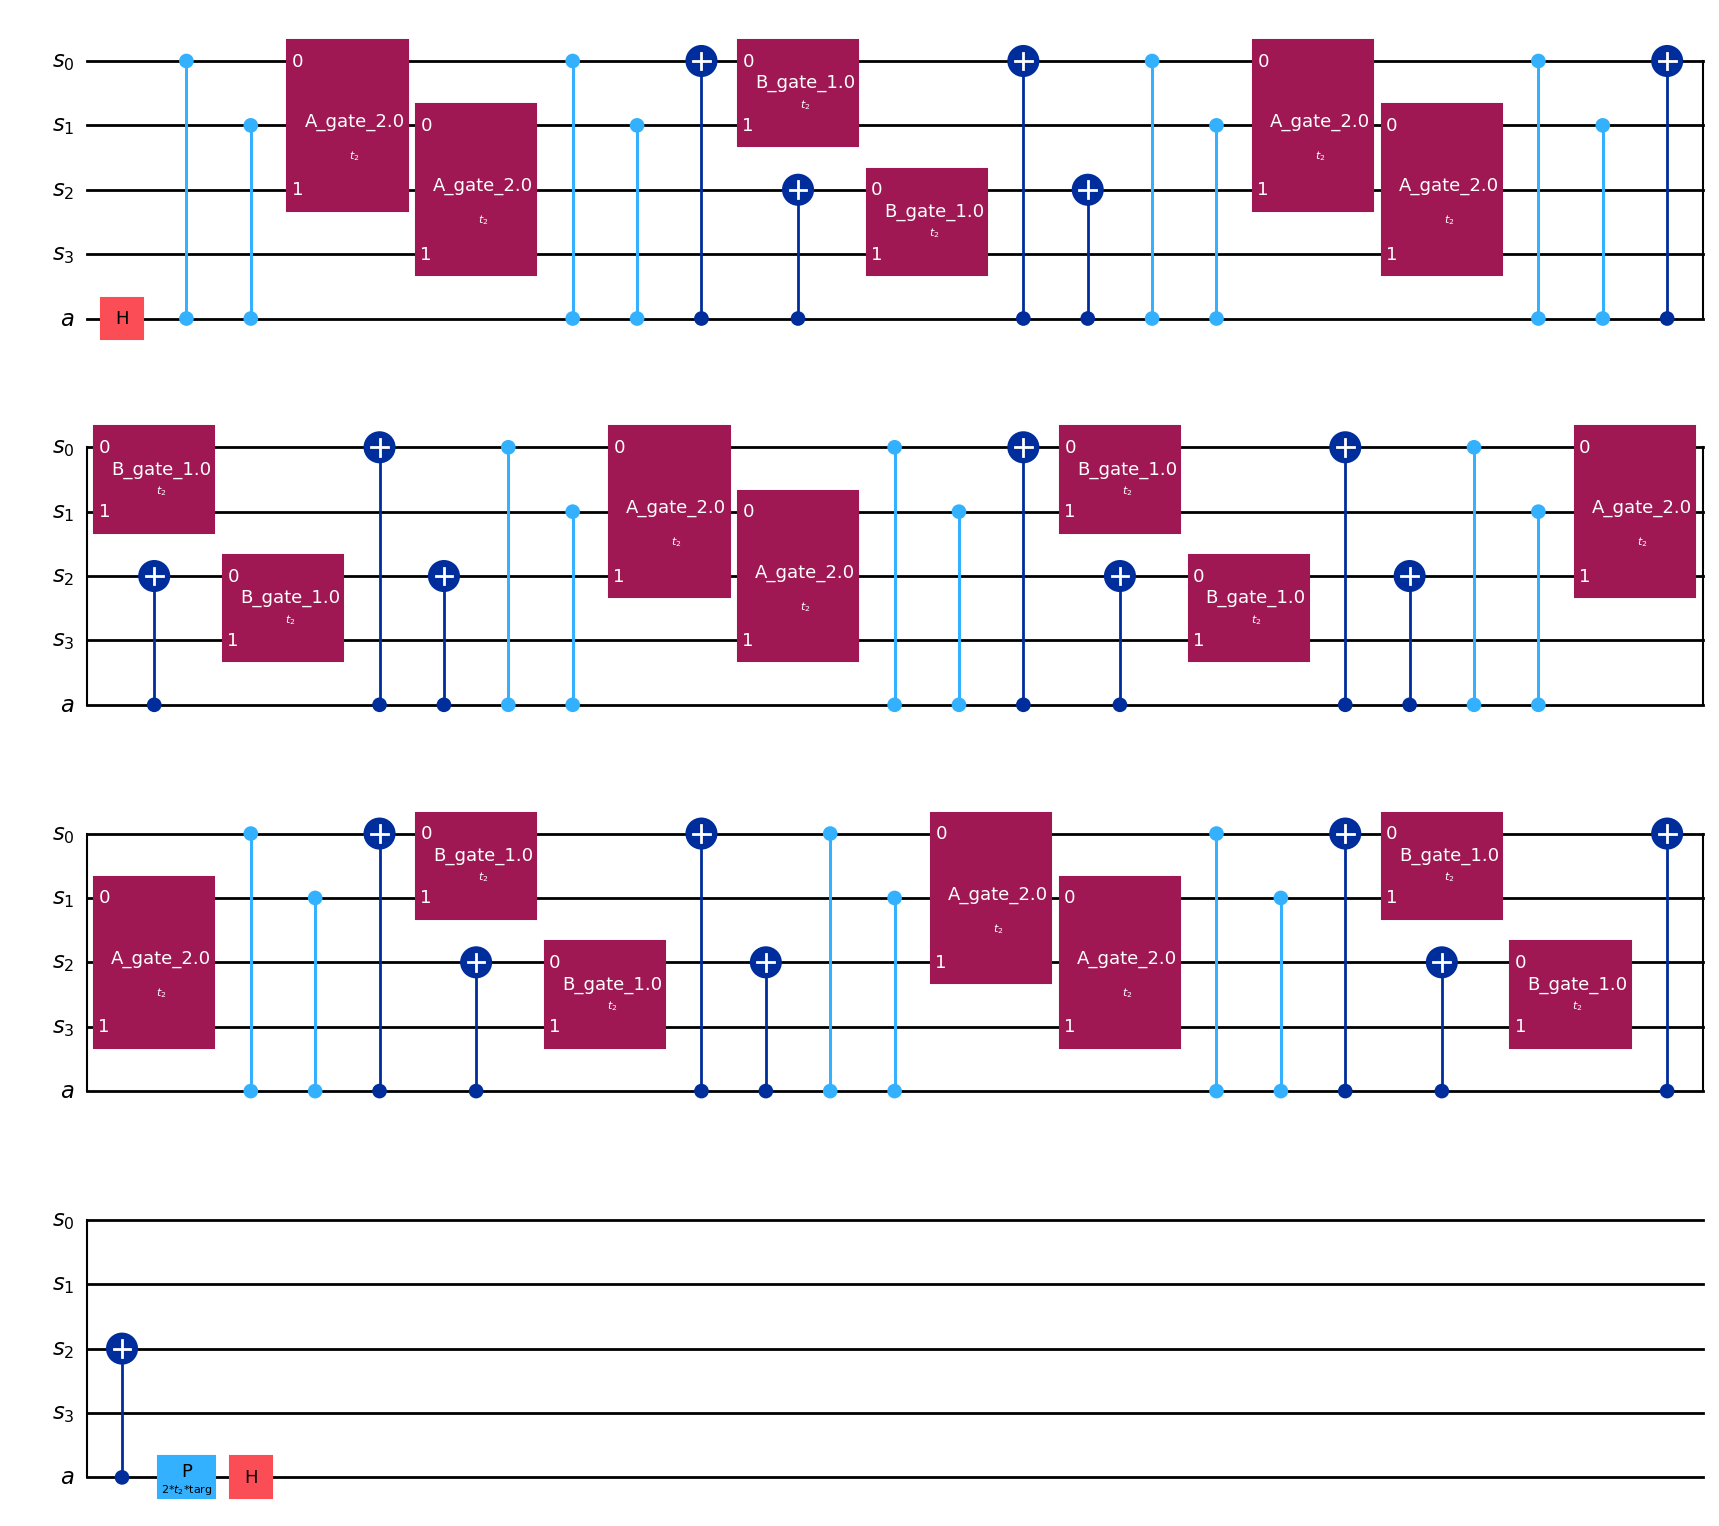

In [2]:
target = Parameter('targ')
rodeo_gate= rodeo_cycle(num_sites=2, J_value=J_input, U_value=U_input, t=time[j], r=steps, targ = target)
rodeo_gate.draw('mpl')

In [ ]:
# Conservation Test
from qiskit.quantum_info import Statevector

circuit = QuantumCircuit(2)
B_gate = create_onsite_gate(U = 100, delta_t = 0.1)
# circuit.x(0)
# circuit.x(1)
circuit.append(B_gate, range(2))

# Get the statevector
state = Statevector.from_instruction(circuit)

# Display the statevector
print("Statevector:", state)


Statevector: Statevector([-0.83907153+0.j,  0.        +0.j, -0.54402111+0.j,
              0.        +0.j],
            dims=(2, 2))


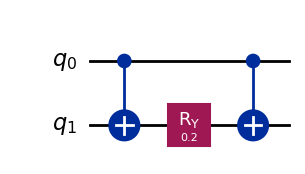

In [20]:
# On-site interaction gate
def create_onsite_gate(U, delta_t):
    onsite_circ = QuantumCircuit(2)
    onsite_circ.cx(0, 1)
    onsite_circ.ry(2 * U * delta_t, 1)
    onsite_circ.cx(0, 1)
    # return onsite_circ.to_gate(label=fr"B_gate_{U}")
    return onsite_circ

circuit = create_onsite_gate(1,0.1)
circuit.draw('mpl')

In [21]:
# Conservation Test for B_gate
from qiskit.quantum_info import Statevector

# Define parameters for the B_gate
U_value = 100
delta_t = 0.1
B_gate = create_onsite_gate(U=U_value, delta_t=delta_t)

# Initial states to test
initial_states = {
    "00": [0, 0],
    "01": [0, 1],
    "10": [1, 0],
    "11": [1, 1]
}

# Apply the B_gate to each initial state and observe the output
for label, init_state in initial_states.items():
    circuit = QuantumCircuit(2)
    
    # Set the initial state
    if init_state[0] == 1:
        circuit.x(0)
    if init_state[1] == 1:
        circuit.x(1)
        
    # Apply the B_gate
    circuit.append(B_gate, range(2))

    # Get the statevector
    state = Statevector.from_instruction(circuit)

    # Display the statevector for analysis
    print(f"Initial state |{label}> after B_gate:")
    print("Statevector:", state)
    print()


Initial state |00> after B_gate:
Statevector: Statevector([-0.83907153+0.j,  0.        +0.j, -0.54402111+0.j,
              0.        +0.j],
            dims=(2, 2))

Initial state |01> after B_gate:
Statevector: Statevector([ 0.54402111+0.j,  0.        +0.j, -0.83907153+0.j,
              0.        +0.j],
            dims=(2, 2))

Initial state |10> after B_gate:
Statevector: Statevector([ 0.        +0.j, -0.83907153+0.j,  0.        +0.j,
              0.54402111+0.j],
            dims=(2, 2))

Initial state |11> after B_gate:
Statevector: Statevector([ 0.        +0.j, -0.54402111+0.j,  0.        +0.j,
             -0.83907153+0.j],
            dims=(2, 2))



Number of target energies: 200
Executing for Target Energy: {Parameter($E_\odot$): -10.0}
Executing for Target Energy: {Parameter($E_\odot$): -9.899497487437186}
Executing for Target Energy: {Parameter($E_\odot$): -9.798994974874372}
Executing for Target Energy: {Parameter($E_\odot$): -9.698492462311558}
Executing for Target Energy: {Parameter($E_\odot$): -9.597989949748744}
Executing for Target Energy: {Parameter($E_\odot$): -9.49748743718593}
Executing for Target Energy: {Parameter($E_\odot$): -9.396984924623116}
Executing for Target Energy: {Parameter($E_\odot$): -9.296482412060302}
Executing for Target Energy: {Parameter($E_\odot$): -9.195979899497488}
Executing for Target Energy: {Parameter($E_\odot$): -9.095477386934673}
Executing for Target Energy: {Parameter($E_\odot$): -8.99497487437186}
Executing for Target Energy: {Parameter($E_\odot$): -8.894472361809045}
Executing for Target Energy: {Parameter($E_\odot$): -8.793969849246231}
Executing for Target Energy: {Parameter($E_\odot

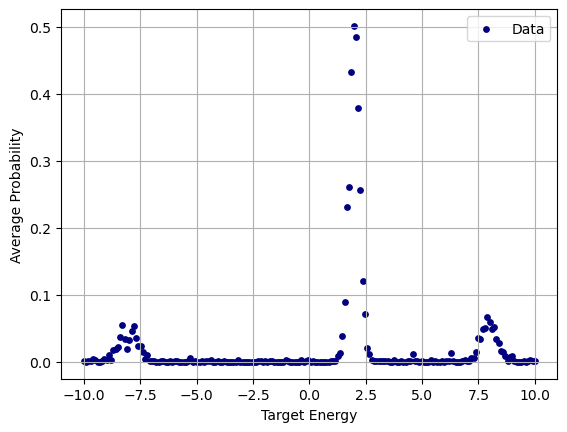

In [2]:
from qiskit_aer.primitives import Sampler
# Enumerate scan energies
energymin = -10
energymax = 10
stepsize = 0.1

targetenergies = np.linspace(energymin, energymax, int((energymax-energymin)/stepsize))
targetenergynum = len(targetenergies)
print("Number of target energies:", targetenergynum)

#Energy window, which should to be slightly larger than stepsize in scan
# Is inverse of sigma parameter
gamma = 1

# Amount of "scrambling" of t per target energy. The more random the t the better. 
timeresamples = 10 # Resampling of times for given target energy
shots_per_same_time = 1024

# Create empty list for data
data = []

# Loop through energy list
for i in range(len(targetenergies)):
    
    # Creates dictionary for target energy parameter
    targ_energy = {target : targetenergies[i]}

    # Below is a troubleshooting line you can use to see if the code is scanning through energies properly
    print("Executing for Target Energy:", targ_energy)
    
    # Initialize a list that will contain the results of all 10 resamples for 1 target energy
    targetenergyrun = []
    for _ in range(timeresamples):
        # Creates random time samples for 1 run
        tsamples = ((1 / gamma) * np.random.randn(cycles)).tolist()
        
        # Creates a dictionary to be able to bind time samples to time parameters
        time_parameter_binds = zip(time, tsamples)
        time_parameters = dict(time_parameter_binds)
        
        # Assigns target energy and time values to parameters
        circuit1 = circuit.assign_parameters(time_parameters, inplace =False)
        circuit2 = circuit1.assign_parameters(targ_energy, inplace = False)
        
        # Runs simulation of circuit with values
        sampler = Sampler()
        job = sampler.run(circuit2)
        job.result()
        quasi_dists = job.result().quasi_dists
        
        # Appends the results to list for this target energy
        targetenergyrun.append(quasi_dists)
    
    # The output from above needs to be post-processed as shown below to gain meaning from it:

    # Flattens list of list of dictionaries into just a list of dictionaries
    flattened_list = []
    for sublist in targetenergyrun:
        flattened_list.extend(sublist)

    # Sums and average dictionaries from multiple timeresamples
    combined_dict = {} 
    for dictionary in flattened_list:
        for key, value in dictionary.items():
            combined_dict[key] = combined_dict.get(key, 0) + value

    average_dict = {}
    for key in combined_dict:
        average_dict[key] = combined_dict[key] / timeresamples

    data.append(average_dict)

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# This extracts the probabilities for the 0 bitcounts from our obtained data
values_list = []
for d in data:
    if 0 in d:
        values_list.append(d[0])
    else:
        values_list.append(0.0)
print(len(values_list))
print(len(targetenergies))

# # Define a Gaussian function
# def gaussian(x, amp, cen, wid):
#     return amp * np.exp(-(x-cen)**2 / (2*wid**2))

# # Define a sum of multiple Gaussians
# def sum_of_gaussians(x, *params):
#     n_gaussians = len(params) // 3
#     result = np.zeros_like(x)
#     for i in range(n_gaussians):
#         amp = params[i*3]
#         cen = params[i*3 + 1]
#         wid = params[i*3 + 2]
#         result += gaussian(x, amp, cen, wid)
#     return result

# # Initial guess for the parameters: amplitudes, centers, and widths of the Gaussians
# initial_guess = [
#     1, -6.28, 1,
#     1, -3.45, 1,
#     1, 0, 1,
# ]

# initial_guess = [
#     1, 0,1

# ]

# # Fit the sum of Gaussians to the data
# popt, pcov = curve_fit(sum_of_gaussians, targetenergies, values_list, p0=initial_guess)

# # Extract the fitted parameters
# fitted_params = popt

# # Generate x values for plotting the fit
# x_fit = np.linspace(min(targetenergies), max(targetenergies), 1000)
# y_fit = sum_of_gaussians(x_fit, *fitted_params)

# Plot the data and the fit
plt.scatter(targetenergies, values_list, label='Data', s= 15, color = 'navy')
plt.grid()
plt.xlabel('Target Energy')
plt.ylabel('Average Probability')
# plt.plot(x_fit, y_fit, color = 'red', label = "Gaussian Fit", linestyle = '--')
# plt.axvline(x = -0.44, color = 'green', label = 'Ground Energy', linestyle = '--')

plt.legend()
plt.show()

# Print the peaks (centers) of the Gaussians
# n_gaussians = len(fitted_params) // 3
# peaks = [fitted_params[i*3 + 1] for i in range(n_gaussians)]
# print(f'The peaks (centers) of the Gaussians are at: {peaks}')


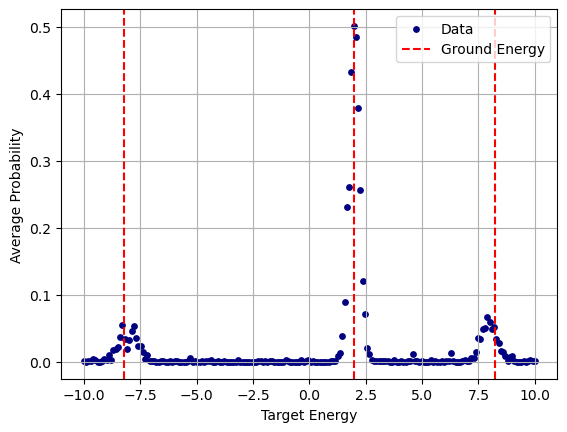

In [6]:
# Plot the data and the fit
plt.scatter(targetenergies, values_list, label='Data', s= 15, color = 'navy')
plt.grid()
plt.xlabel('Target Energy')
plt.ylabel('Average Probability')
# plt.plot(x_fit, y_fit, color = 'red', label = "Gaussian Fit", linestyle = '--')
plt.axvline(x = -8.24, color = 'red', label = 'Ground Energy', linestyle = '--')
plt.axvline(x = 2, color = 'red', linestyle = '--')
plt.axvline(x = 8.24, color = 'red', linestyle = '--')

plt.legend()
plt.show()

In [68]:
values0110 = values_list

In [65]:
values1001 = values_list

In [62]:
values0011 = values_list

In [57]:
values1100 = values_list

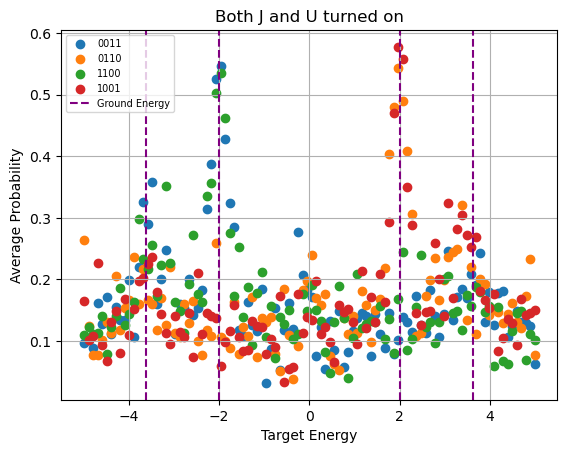

In [70]:
# # Define a Gaussian function
# def gaussian(x, amp, cen, wid):
#     return amp * np.exp(-(x-cen)**2 / (2*wid**2))

# # Define a sum of multiple Gaussians
# def sum_of_gaussians(x, *params):
#     n_gaussians = len(params) // 3
#     result = np.zeros_like(x)
#     for i in range(n_gaussians):
#         amp = params[i*3]
#         cen = params[i*3 + 1]
#         wid = params[i*3 + 2]
#         result += gaussian(x, amp, cen, wid)
#     return result

# # Initial guess for the parameters: amplitudes, centers, and widths of the Gaussians
# initial_guess = [
#     1, -6.28, 1,
#     1, -3.45, 1,
#     1, 0, 1,
# ]

# initial_guess = [
#     1, 0,1

# ]

# # Fit the sum of Gaussians to the data
# popt, pcov = curve_fit(sum_of_gaussians, targetenergies, values_list, p0=initial_guess)

# # Extract the fitted parameters
# fitted_params = popt

# # Generate x values for plotting the fit
# x_fit = np.linspace(min(targetenergies), max(targetenergies), 1000)
# y_fit = sum_of_gaussians(x_fit, *fitted_params)

# total_sum = np.array(values0110)+np.array(values1001)+np.array(values1100)+np.array(values0011)
# Plot the data and the fit
# plt.scatter(targetenergies, total_sum/np.sum(total_sum), label='Data', s= 15, color = 'navy')
plt.scatter(targetenergies, values0011, label = '0011')
plt.scatter(targetenergies, values0110, label = '0110')
plt.scatter(targetenergies, values1100, label = '1100')
plt.scatter(targetenergies, values1001, label = '1001')
plt.grid()
plt.xlabel('Target Energy')
plt.ylabel('Average Probability')
# plt.plot(x_fit, y_fit, color = 'red', label = "Gaussian Fit", linestyle = '--')
plt.axvline(x = 2, color = 'purple', label = 'Ground Energy', linestyle = '--')
plt.axvline(x = 3.63, color = 'purple', linestyle = '--')
plt.axvline(x = -2, color = 'purple', linestyle = '--')
plt.axvline(x = -3.63, color = 'purple', linestyle = '--')
plt.title('Both J and U turned on')
# plt.axvline(x = -4.47, color = 'red', label = 'Ground Energy', linestyle = '--')
# plt.axvline(x = 0, color = 'red', label = 'Ground Energy', linestyle = '--')
# plt.axvline(x = 4, color = 'red', label = 'Ground Energy', linestyle = '--')
# plt.axvline(x = 4.47, color = 'red', label = 'Ground Energy', linestyle = '--')

plt.legend(fontsize = 7, loc = 'upper left')
plt.show()

# Print the peaks (centers) of the Gaussians
# n_gaussians = len(fitted_params) // 3
# peaks = [fitted_params[i*3 + 1] for i in range(n_gaussians)]
# print(f'The peaks (centers) of the Gaussians are at: {peaks}')

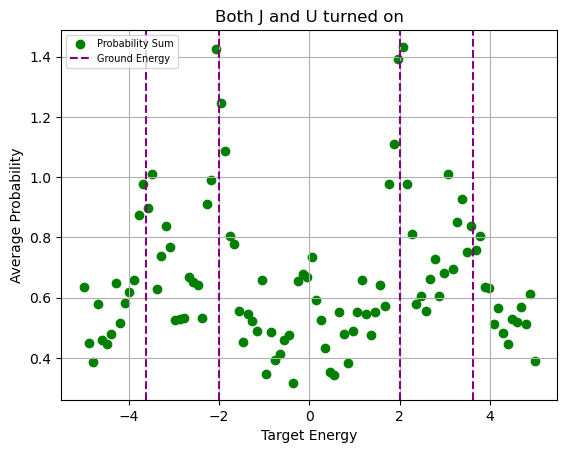

In [80]:
# # Define a Gaussian function
# def gaussian(x, amp, cen, wid):
#     return amp * np.exp(-(x-cen)**2 / (2*wid**2))

# # Define a sum of multiple Gaussians
# def sum_of_gaussians(x, *params):
#     n_gaussians = len(params) // 3
#     result = np.zeros_like(x)
#     for i in range(n_gaussians):
#         amp = params[i*3]
#         cen = params[i*3 + 1]
#         wid = params[i*3 + 2]
#         result += gaussian(x, amp, cen, wid)
#     return result

# # Initial guess for the parameters: amplitudes, centers, and widths of the Gaussians
# initial_guess = [
#     1, -6.28, 1,
#     1, -3.45, 1,
#     1, 0, 1,
# ]

# initial_guess = [
#     1, 0,1

# ]

# # Fit the sum of Gaussians to the data
# popt, pcov = curve_fit(sum_of_gaussians, targetenergies, values_list, p0=initial_guess)

# # Extract the fitted parameters
# fitted_params = popt

# # Generate x values for plotting the fit
# x_fit = np.linspace(min(targetenergies), max(targetenergies), 1000)
# y_fit = sum_of_gaussians(x_fit, *fitted_params)

# total_sum = np.array(values0110)+np.array(values1001)+np.array(values1100)+np.array(values0011)
# Plot the data and the fit
# plt.scatter(targetenergies, total_sum/np.sum(total_sum), label='Data', s= 15, color = 'navy')
plt.scatter(targetenergies, np.array(values0011)+np.array(values0110)+np.array(values1100)+np.array(values1001), label = 'Probability Sum',
            marker = 'o', color = 'green')
# plt.scatter(targetenergies, values0110, label = '0110')
# plt.scatter(targetenergies, values1100, label = '1100')
# plt.scatter(targetenergies, values1001, label = '1001')
plt.grid()
plt.xlabel('Target Energy')
plt.ylabel('Average Probability')
# plt.plot(x_fit, y_fit, color = 'red', label = "Gaussian Fit", linestyle = '--')
plt.axvline(x = 2, color = 'purple', label = 'Ground Energy', linestyle = '--')
plt.axvline(x = 3.63, color = 'purple', linestyle = '--')
plt.axvline(x = -2, color = 'purple', linestyle = '--')
plt.axvline(x = -3.63, color = 'purple', linestyle = '--')
plt.title('Both J and U turned on')
# plt.axvline(x = -4.47, color = 'red', label = 'Ground Energy', linestyle = '--')
# plt.axvline(x = 0, color = 'red', label = 'Ground Energy', linestyle = '--')
# plt.axvline(x = 4, color = 'red', label = 'Ground Energy', linestyle = '--')
# plt.axvline(x = 4.47, color = 'red', label = 'Ground Energy', linestyle = '--')

plt.legend(fontsize = 7, loc = 'upper left')
plt.show()

# Print the peaks (centers) of the Gaussians
# n_gaussians = len(fitted_params) // 3
# peaks = [fitted_params[i*3 + 1] for i in range(n_gaussians)]
# print(f'The peaks (centers) of the Gaussians are at: {peaks}')

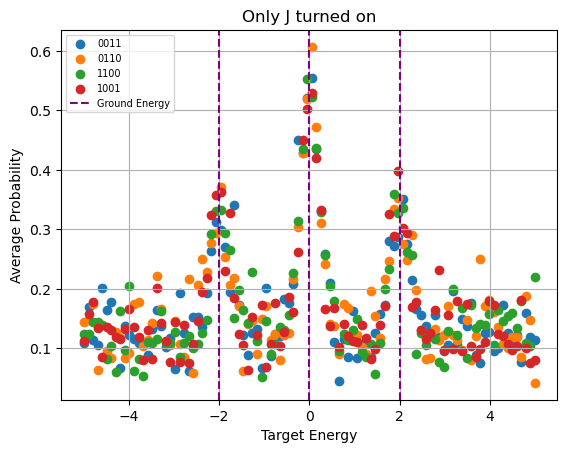

In [18]:
# # Define a Gaussian function
# def gaussian(x, amp, cen, wid):
#     return amp * np.exp(-(x-cen)**2 / (2*wid**2))

# # Define a sum of multiple Gaussians
# def sum_of_gaussians(x, *params):
#     n_gaussians = len(params) // 3
#     result = np.zeros_like(x)
#     for i in range(n_gaussians):
#         amp = params[i*3]
#         cen = params[i*3 + 1]
#         wid = params[i*3 + 2]
#         result += gaussian(x, amp, cen, wid)
#     return result

# # Initial guess for the parameters: amplitudes, centers, and widths of the Gaussians
# initial_guess = [
#     1, -6.28, 1,
#     1, -3.45, 1,
#     1, 0, 1,
# ]

# initial_guess = [
#     1, 0,1

# ]

# # Fit the sum of Gaussians to the data
# popt, pcov = curve_fit(sum_of_gaussians, targetenergies, values_list, p0=initial_guess)

# # Extract the fitted parameters
# fitted_params = popt

# # Generate x values for plotting the fit
# x_fit = np.linspace(min(targetenergies), max(targetenergies), 1000)
# y_fit = sum_of_gaussians(x_fit, *fitted_params)

total_sum = np.array(values0110)+np.array(values1001)+np.array(values1100)+np.array(values0011)
# Plot the data and the fit
# plt.scatter(targetenergies, total_sum/np.sum(total_sum), label='Data', s= 15, color = 'navy')
plt.scatter(targetenergies, values0011, label = '0011')
plt.scatter(targetenergies, values0110, label = '0110')
plt.scatter(targetenergies, values1100, label = '1100')
plt.scatter(targetenergies, values1001, label = '1001')
plt.grid()
plt.xlabel('Target Energy')
plt.ylabel('Average Probability')
# plt.plot(x_fit, y_fit, color = 'red', label = "Gaussian Fit", linestyle = '--')
plt.axvline(x = 2, color = 'purple', label = 'Ground Energy', linestyle = '--')
plt.axvline(x = 0, color = 'purple', linestyle = '--')
plt.axvline(x = -2, color = 'purple', linestyle = '--')
plt.title('Only J turned on')
# plt.axvline(x = -4.47, color = 'red', label = 'Ground Energy', linestyle = '--')
# plt.axvline(x = 0, color = 'red', label = 'Ground Energy', linestyle = '--')
# plt.axvline(x = 4, color = 'red', label = 'Ground Energy', linestyle = '--')
# plt.axvline(x = 4.47, color = 'red', label = 'Ground Energy', linestyle = '--')

plt.legend(fontsize = 7, loc = 'upper left')
plt.show()

# Print the peaks (centers) of the Gaussians
# n_gaussians = len(fitted_params) // 3
# peaks = [fitted_params[i*3 + 1] for i in range(n_gaussians)]
# print(f'The peaks (centers) of the Gaussians are at: {peaks}')

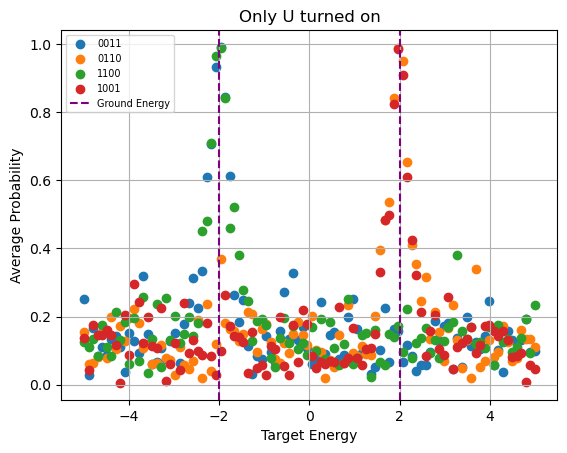

In [29]:
# # Define a Gaussian function
# def gaussian(x, amp, cen, wid):
#     return amp * np.exp(-(x-cen)**2 / (2*wid**2))

# # Define a sum of multiple Gaussians
# def sum_of_gaussians(x, *params):
#     n_gaussians = len(params) // 3
#     result = np.zeros_like(x)
#     for i in range(n_gaussians):
#         amp = params[i*3]
#         cen = params[i*3 + 1]
#         wid = params[i*3 + 2]
#         result += gaussian(x, amp, cen, wid)
#     return result

# # Initial guess for the parameters: amplitudes, centers, and widths of the Gaussians
# initial_guess = [
#     1, -6.28, 1,
#     1, -3.45, 1,
#     1, 0, 1,
# ]

# initial_guess = [
#     1, 0,1

# ]

# # Fit the sum of Gaussians to the data
# popt, pcov = curve_fit(sum_of_gaussians, targetenergies, values_list, p0=initial_guess)

# # Extract the fitted parameters
# fitted_params = popt

# # Generate x values for plotting the fit
# x_fit = np.linspace(min(targetenergies), max(targetenergies), 1000)
# y_fit = sum_of_gaussians(x_fit, *fitted_params)

total_sum = np.array(values0110)+np.array(values1001)+np.array(values1100)+np.array(values0011)
# Plot the data and the fit
# plt.scatter(targetenergies, total_sum/np.sum(total_sum), label='Data', s= 15, color = 'navy')
plt.scatter(targetenergies, values0011, label = '0011')
plt.scatter(targetenergies, values0110, label = '0110')
plt.scatter(targetenergies, values1100, label = '1100')
plt.scatter(targetenergies, values1001, label = '1001')
plt.grid()
plt.xlabel('Target Energy')
plt.ylabel('Average Probability')
# plt.plot(x_fit, y_fit, color = 'red', label = "Gaussian Fit", linestyle = '--')
plt.axvline(x = 2, color = 'purple', label = 'Ground Energy', linestyle = '--')
# plt.axvline(x = 4.47, color = 'red', label = 'Ground Energy', linestyle = '--')
plt.axvline(x = -2, color = 'purple', linestyle = '--')
plt.title('Only U turned on')
# plt.axvline(x = -4.47, color = 'red', label = 'Ground Energy', linestyle = '--')
# plt.axvline(x = 0, color = 'red', label = 'Ground Energy', linestyle = '--')
# plt.axvline(x = 4, color = 'red', label = 'Ground Energy', linestyle = '--')
# plt.axvline(x = 4.47, color = 'red', label = 'Ground Energy', linestyle = '--')

plt.legend(fontsize = 7, loc = 'upper left')
plt.show()

# Print the peaks (centers) of the Gaussians
# n_gaussians = len(fitted_params) // 3
# peaks = [fitted_params[i*3 + 1] for i in range(n_gaussians)]
# print(f'The peaks (centers) of the Gaussians are at: {peaks}')